# Heart Disease Analytics with Healthy Skepticism

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV fIle I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from time import time
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

print(os.listdir("../input"))

['heart.csv']


#### Objectives:
In this notebook, I will attempt to find the main contributors to heart disease through the UCI Heart Disease dataset.<br>
My approach will include Exploratory Data Analysis, Feature Engineering (minimal required in this example), Testing Multiple Models, including several with GridSearch, and one-by-one analysis the models' top features as they relate current medical knowledge.

References:
- https://www.kaggle.com/rgoodman/elo-merchant-with-no-peeking-at-other-kernels
- My ML Donors Udacity Project
- https://github.com/dmitriyboyuk/sl_classifier_framework-master/blob/master/finding_opportunity_segment_v1.ipynb

## Exploratory Data Analysis

- age: The person's age in years
- sex: The person's sex (1 = male, 0 = female)
- cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)
- chol: The person's cholesterol measurement in mg/dl
- fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
- restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- thalach: The person's maximum heart rate achieved
- exang: Exercise induced angina (1 = yes; 0 = no)
- oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot)
- slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- ca: The number of major vessels (0-3)
- thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
- target: Heart disease (0 = no, 1 = yes)

**Reading into the descriptions of the features of the dataset, it looks like a few of them should be reclassified as categoricals instead of numerical features.**
- cp
- restecg
- slope
- thal

In [2]:
df = pd.read_csv("../input/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df.shape

(303, 14)

There are only 303 records, and it's questionable as to whether this sample size will be enough to arrive at significant and reliable conclusions regarding the most important factors for heart disease.

In [4]:
categoricals = ['cp','restecg','slope','thal']
df[categoricals].head(2)

,cp,restecg,slope,thal
0,3,0,0,1
1,2,1,0,2


In [5]:
numerics = np.setdiff1d(df.columns.tolist(),categoricals)
df[numerics].head(3)

,age,ca,chol,exang,fbs,oldpeak,sex,target,thalach,trestbps
0,63,0,233,0,1,2.3,1,1,150,145
1,37,0,250,0,0,3.5,1,1,187,130
2,41,0,204,0,0,1.4,0,1,172,130


In [6]:
# There aren't any null values
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

#### Let's look for any meaningful outliers

In [7]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


The only distribution of concern is **chol**, which is total cholesterol.  The maximum is more than twice the 75th percentile.

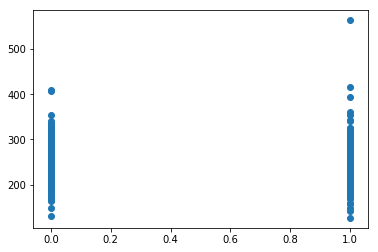

In [8]:
plt.scatter(df['target'],df['chol']);

In [9]:
#We do see this individual as an extreme outlier, but I will leave this in the model.
#I am curious to see their other attributes however next to the rest of the distributions shown in the "describe" method.
df[df['chol']==564]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
85,67,0,2,115,564,0,0,160,0,1.6,1,0,3,1


In [10]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


The individual doesn't stand out too much in any other areas, so I don't want to take them from input to the model since they don't seem like they will distort training with only one feature as an extreme.

In [11]:
df['thal'].max()

3

In [12]:
pd.get_dummies(df[categoricals].astype(str)).head()

,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,0,0,0,1,1,0,0,1,0,0,0,1,0,0
1,0,0,1,0,0,1,0,1,0,0,0,0,1,0
2,0,1,0,0,1,0,0,0,0,1,0,0,1,0
3,0,1,0,0,0,1,0,0,0,1,0,0,1,0
4,1,0,0,0,0,1,0,0,0,1,0,0,1,0


Before passing the numerical features to the model, it's important to see if there is skewness in the distributions.

In [13]:
skew_calcs = df[numerics].skew()
skew_calcs[abs(skew_calcs)>0.7]

ca          1.310422
chol        1.143401
exang       0.742532
fbs         1.986652
oldpeak     1.269720
sex        -0.791335
trestbps    0.713768
dtype: float64

In [14]:
skewed_features = skew_calcs[skew_calcs.abs()>0.7].index.tolist()
skewed_features

['ca', 'chol', 'exang', 'fbs', 'oldpeak', 'sex', 'trestbps']

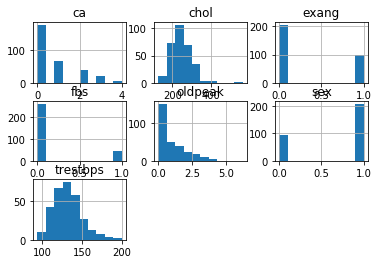

In [15]:
df[skewed_features].hist();

#### The distribution of log-transformed features below does not appear to improve the distribution to appear more "normal", so I will stick with the original features without any transformation.

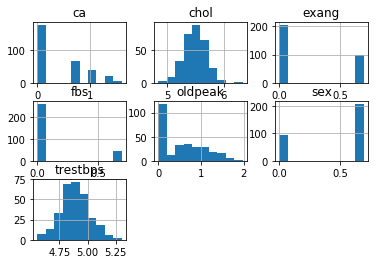

In [16]:
np.log1p(df[skewed_features]).hist();

In [17]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


**Created dummy variables for the categoricals and looks like everything merged/joined correctly.**

In [18]:
modeldata = pd.merge(df[numerics],pd.get_dummies(df[categoricals].astype(str)),left_index = True, right_index = True,how = 'inner')
modeldata.head()

,age,ca,chol,exang,fbs,oldpeak,sex,target,thalach,trestbps,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,63,0,233,0,1,2.3,1,1,150,145,0,0,0,1,1,0,0,1,0,0,0,1,0,0
1,37,0,250,0,0,3.5,1,1,187,130,0,0,1,0,0,1,0,1,0,0,0,0,1,0
2,41,0,204,0,0,1.4,0,1,172,130,0,1,0,0,1,0,0,0,0,1,0,0,1,0
3,56,0,236,0,0,0.8,1,1,178,120,0,1,0,0,0,1,0,0,0,1,0,0,1,0
4,57,0,354,1,0,0.6,0,1,163,120,1,0,0,0,0,1,0,0,0,1,0,0,1,0


## Prep Model for Training and Validation

In [19]:
from sklearn.model_selection import train_test_split
X, y = modeldata.drop(['target'],axis = 1), modeldata['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### Metrics

#### I will use accuracy score and f_score as my metrics for this binary classification problem.
I will look at **f_score**, since this is interesting and relevant in practice when looking at the potential for a disease.  I will set beta at .8, weighting recall more heavily than precision with the idea that this could be used as an indicator to take preventative action.  While only theoretical, this higher recall sensitivity would potentially be used to encourage change in behavior like diet and exercise.  One would possibly argue that this sensitivity would be too high if the outcome were related to actual prescription of medications related to heart disease.<br>

**Accuracy score** will be the most relevant measure for my purposes, since I am looking primarily for which features are most important in predicting the incidence of heart disease.  So, accuracy score will weight false positives and false negatives equally.

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score, accuracy_score

In [21]:
def train_predict_with_parameters(learner, X_train, y_train, X_test, y_test,parameters = {}): 
    results = {}
    start = time() # Get start time
    if parameters != {}:
        clf = GridSearchCV(learner, parameters)
        learner = clf.fit(X_train,y_train)
        results['best_params'] = learner.best_params_
    else:
        learner = learner.fit(X_train,y_train)
        results['best_params'] = ''
    end = time() # Get end time
    results['train_time'] = end - start
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    results['pred_time'] = end - start
    results['acc_train'] = accuracy_score(y_train,predictions_train)
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    results['f_train'] = fbeta_score(y_train,predictions_train,.8)
    results['f_test'] = fbeta_score(y_test,predictions_test,.8)
    #results['best_params'] = learner.best_params_
    return results

In [22]:
learners= []

from sklearn.linear_model import LogisticRegression
learners.append([LogisticRegression(),{}])

from sklearn.tree import DecisionTreeClassifier
learners.append([DecisionTreeClassifier(),{}])

from sklearn.neighbors import KNeighborsClassifier
learners.append([KNeighborsClassifier(),{}])

from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier 
learners.append([GradientBoostingClassifier(),{ 'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] }])
learners.append([AdaBoostClassifier(),{'n_estimators': [16, 32]}])

learners.append([BaggingClassifier(),{}])
learners.append([RandomForestClassifier(),
                 {'bootstrap': [True, False],
                 'max_depth': [3, 5, 10, 20, None],
                 'max_features': ['auto', 'sqrt'],
                 'min_samples_leaf': [1, 2, 4],
                 'min_samples_split': [2, 5, 10]}
                ])

learners.append([RandomForestClassifier(),{}])

from sklearn.svm import LinearSVC, SVC
learners.append([SVC(),{'kernel': ['linear', 'rbf'],'C':[1, 10]}])
learners.append([LinearSVC(),{}])

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
learners.append([BernoulliNB(),{}])
learners.append([GaussianNB(),{}])
learners.append([MultinomialNB(),{}])

In [23]:
results = {}
for clf in learners:
    #No Params
    clf_name = clf[0].__class__.__name__
    results[clf_name] = train_predict_with_parameters(clf[0], X_train, y_train, X_test, y_test)
    #GridSearchCV
    if clf[1] != {}:
        clf_name = clf[0].__class__.__name__
        results[str(clf_name) + '_gridsearch'] = train_predict_with_parameters(clf[0], X_train, y_train, X_test, y_test, clf[1])

In [24]:
pd.DataFrame.from_dict(results).transpose().sort_values(['f_test','acc_test'], ascending = [False,False])

,acc_test,acc_train,best_params,f_test,f_train,pred_time,train_time
BernoulliNB,0.852459,0.838843,,0.826764,0.860242,0.00175166,0.00177836
GaussianNB,0.852459,0.838843,,0.826468,0.85886,0.00153112,0.00116801
AdaBoostClassifier,0.836066,0.942149,,0.808244,0.948513,0.0117638,0.0585916
GradientBoostingClassifier,0.803279,0.995868,,0.771505,0.995632,0.00311065,0.0689733
GradientBoostingClassifier_gridsearch,0.803279,1,"{'learning_rate': 0.8, 'n_estimators': 32}",0.771505,1,0.00184131,0.242331
AdaBoostClassifier_gridsearch,0.803279,0.88843,{'n_estimators': 16},0.771505,0.901801,0.00483322,0.235264
RandomForestClassifier,0.803279,0.991736,,0.771505,0.992806,0.00356936,0.0103979
RandomForestClassifier_gridsearch,0.786885,0.92562,"{'bootstrap': False, 'max_depth': 5, 'max_feat...",0.757347,0.928583,0.00354147,8.05436
BaggingClassifier,0.786885,0.987603,,0.754601,0.989954,0.00381064,0.0142343
SVC_gridsearch,0.770492,0.867769,"{'C': 10, 'kernel': 'linear'}",0.738422,0.883228,0.00280714,14.4033


### Voting Classifier

My Final model will be a VotingClassifier based on the top-scoring models above.  I chose the top three models, but I only used one of the Naive Bayes models (I picked BernoulliNB), because the logic they use to train will be very similar.  So, I wouldn't expect any added value from an ensemble such similar models.

In [25]:
from sklearn.ensemble import VotingClassifier

In [26]:
clf1 = BernoulliNB()
clf2 = RandomForestClassifier()
clf3 = AdaBoostClassifier()
eclf1 = VotingClassifier(estimators=[('bnb', clf1), ('rf', clf2), ('ab', clf3)], voting='hard')
#If ‘hard’, uses predicted class labels for majority rule voting. Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.


In [27]:
clf_name = eclf1.__class__.__name__
results[clf_name] = train_predict_with_parameters(eclf1, X_train, y_train, X_test, y_test)
pd.DataFrame.from_dict(results).transpose().sort_values(['f_test','acc_test'], ascending = [False,False])

,acc_test,acc_train,best_params,f_test,f_train,pred_time,train_time
BernoulliNB,0.852459,0.838843,,0.826764,0.860242,0.00175166,0.00177836
GaussianNB,0.852459,0.838843,,0.826468,0.85886,0.00153112,0.00116801
AdaBoostClassifier,0.836066,0.942149,,0.808244,0.948513,0.0117638,0.0585916
GradientBoostingClassifier,0.803279,0.995868,,0.771505,0.995632,0.00311065,0.0689733
GradientBoostingClassifier_gridsearch,0.803279,1,"{'learning_rate': 0.8, 'n_estimators': 32}",0.771505,1,0.00184131,0.242331
AdaBoostClassifier_gridsearch,0.803279,0.88843,{'n_estimators': 16},0.771505,0.901801,0.00483322,0.235264
RandomForestClassifier,0.803279,0.991736,,0.771505,0.992806,0.00356936,0.0103979
VotingClassifier,0.803279,0.950413,,0.771505,0.956835,0.0189209,0.0718758
RandomForestClassifier_gridsearch,0.786885,0.92562,"{'bootstrap': False, 'max_depth': 5, 'max_feat...",0.757347,0.928583,0.00354147,8.05436
BaggingClassifier,0.786885,0.987603,,0.754601,0.989954,0.00381064,0.0142343


## Now to dig into some model results.

In [28]:
#We'll be using this function a few times to show feature importances

def show_importances(importances,vars = 8):
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:vars]]
    values = importances[indices][:vars]
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(vars), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(vars) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(vars), columns)
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()

### Bagging Classifier:
#### Let's take a closer look

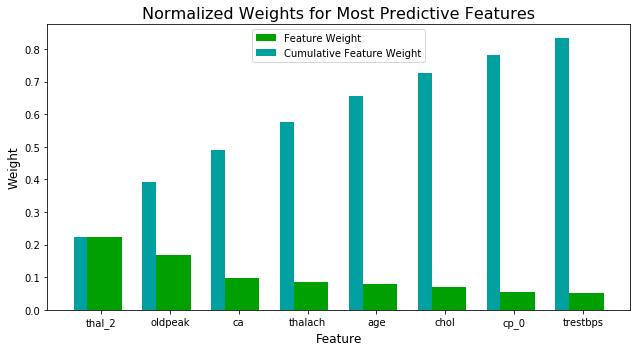

In [29]:
clf = BaggingClassifier()
clf.fit(X, y)

importances = np.mean([
    tree.feature_importances_ for tree in clf.estimators_
], axis=0)

show_importances(importances,8)

### We'll look more closely into the top four above:
- **thal_2**
- **cp_0**
- **ca**
- **oldpeak**

In [30]:
### Let's distinguish by target to see the distributions of the features by target
target1 = modeldata[modeldata['target']==1]
target0 = modeldata[modeldata['target']==0]

- **oldpeak**
- **ca**
<br>**Below we see that oldpeak and ca values of zero are positively correlated with the presence of heart disease.** 
<br>We will also see this in the correlation table below, where there are 4th and 5th most negatively correlated features.

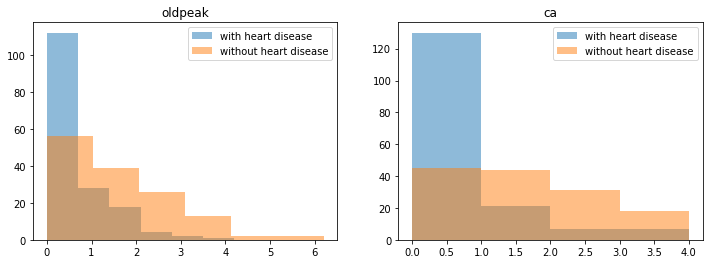

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))

ax1.hist(target1['oldpeak'],int(modeldata['oldpeak'].max()),alpha = 0.5, label = 'with heart disease')
ax1.hist(target0['oldpeak'],int(modeldata['oldpeak'].max()),alpha = 0.5, label = 'without heart disease')
ax1.title.set_text('oldpeak')
ax1.legend(loc=0)

ax2.hist(target1['ca'],int(modeldata['ca'].max()),alpha = 0.5, label = 'with heart disease')
ax2.hist(target0['ca'],int(modeldata['ca'].max()),alpha = 0.5, label = 'without heart disease')
ax2.title.set_text('ca')
ax2.legend(loc=0);

In [32]:
modeldata.corr()['target'].sort_values().head(5)

cp_0      -0.516015
thal_3    -0.486112
exang     -0.436757
oldpeak   -0.430696
ca        -0.391724
Name: target, dtype: float64

- **cp_0**
<br>Above we also saw how **cp_0** (typical angina) is the most negatively correlated feature with heart disease.

In [33]:
cp0 = modeldata[['cp_0','target']]
cp0['combined'] = modeldata['cp_0'] * modeldata['target']

print('{}% of all had heart disease%'.format(round(df['target'].sum()/df.shape[0]*100,0)))
print('{}% of those with cp_0 had heart disease%'.format(round(39/143*100,0)))
cp0.sum()

54.0% of all had heart disease%
27.0% of those with cp_0 had heart disease%


cp_0        143
target      165
combined     39
dtype: int64

In [34]:
pd.merge(pd.get_dummies(df['thal']), df[['target']], left_index = True, right_index = True, how = 'inner').corr()['target']

0        -0.007293
1        -0.106589
2         0.527334
3        -0.486112
target    1.000000
Name: target, dtype: float64

In [35]:
modeldata.corr()['target'].sort_values().head(5)

cp_0      -0.516015
thal_3    -0.486112
exang     -0.436757
oldpeak   -0.430696
ca        -0.391724
Name: target, dtype: float64

- **thal_2**
<br>With the statistics and correlation table below, we see that **thal_2** is the most highly correlated feature with heart disease.

In [36]:
print('{}% of those with thal_2 had heart disease%'.format(round(130/166*100,0)))
thal2 = modeldata[['thal_2','target']]
thal2['combined'] = modeldata['thal_2'] * modeldata['target']
thal2.sum()

78.0% of those with thal_2 had heart disease%


thal_2      166
target      165
combined    130
dtype: int64

In [37]:
modeldata.corr()['target'].sort_values(ascending = False).head(10)

target       1.000000
thal_2       0.527334
thalach      0.421741
slope_2      0.394066
cp_2         0.316742
cp_1         0.245879
restecg_1    0.175322
cp_3         0.086957
thal_0      -0.007293
fbs         -0.028046
Name: target, dtype: float64

We can also see how much more positively correlated thal_2 is with heart disease than the other thalassemia categories.

In [38]:
pd.merge(pd.get_dummies(df['thal']), df[['target']], left_index = True, right_index = True, how = 'inner').corr()['target']

0        -0.007293
1        -0.106589
2         0.527334
3        -0.486112
target    1.000000
Name: target, dtype: float64

### RandomForestClassifier:
#### Let's take a closer look

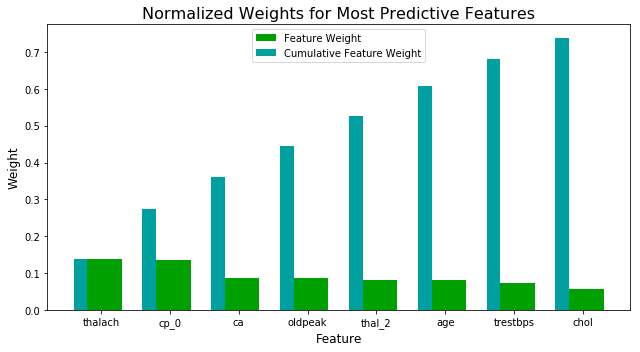

In [39]:
clf = RandomForestClassifier()
clf.fit(X,y)

importances = np.mean([
    tree.feature_importances_ for tree in clf.estimators_
], axis=0)

show_importances(importances,8)

### It's nice to see 3 of our top four features are the same.

### thalach is the new feature in the top four, so let's take a closer look

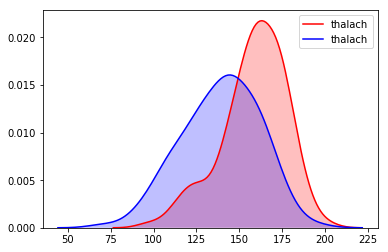

In [40]:
sns.kdeplot(data = target1['thalach'],color = 'red',shade = True)#,bw=True)
sns.kdeplot(data = target0['thalach'],color = 'blue',shade = True)#, bw = True)
plt.show()    

Higher rates of **thalach**, the maximum heart rate achieved, are correlated with a greater incidence of heart disease.

### AdaBoostClassifier:
#### Let's take a closer look

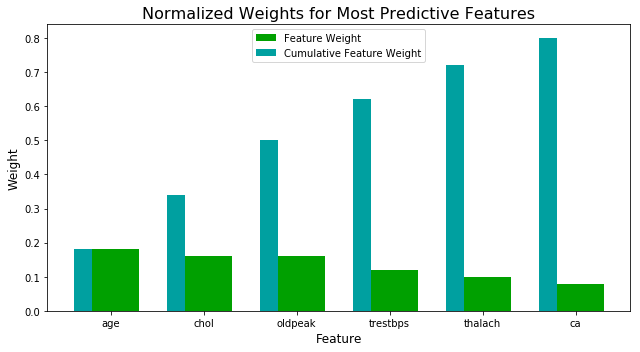

In [41]:
clf = AdaBoostClassifier()
clf.fit(X,y)

importances = np.mean([
    tree.feature_importances_ for tree in clf.estimators_
], axis=0)
    
show_importances(importances,6)    

### We'll look more closely into the top four above, with the exception of oldpeak, which we've already looked into.
- **age**
- **chol**
- **trestbps**

The Adaboost throws some curveballs for us, as you can see below.

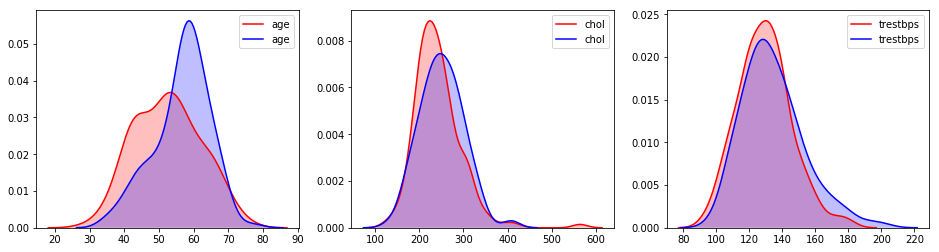

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16,4))

sns.kdeplot(data = target1['age'],color = 'red',shade = True, ax = ax1)#,bw=True)
sns.kdeplot(data = target0['age'],color = 'blue',shade = True, ax = ax1)#, bw = True)

sns.kdeplot(data = target1['chol'],color = 'red',shade = True, ax = ax2)#,bw=True)
sns.kdeplot(data = target0['chol'],color = 'blue',shade = True, ax = ax2)#, bw = True)

sns.kdeplot(data = target1['trestbps'],color = 'red',shade = True, ax = ax3)#,bw=True)
sns.kdeplot(data = target0['trestbps'],color = 'blue',shade = True, ax = ax3)#, bw = True)
plt.show()    

In [43]:
modeldata[['target','age','chol','trestbps']].corr()['target'].sort_values()

age        -0.225439
trestbps   -0.144931
chol       -0.085239
target      1.000000
Name: target, dtype: float64

We can see both visually and with the correlation table that these three features are negatively correlated with the presence of heart disease.  This will, however, pose a bit of a problem to our study.  We will find that as we seek out external research, these three figures should have a positive correlation with heart disease.

### Let's take a look at the feature importance of the ensemble VotingClassifier I created.

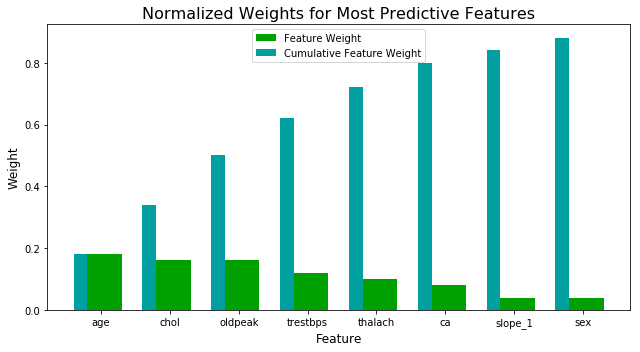

In [44]:
eclf1.fit(X, y)

importances = np.mean([
    tree.feature_importances_ for tree in clf.estimators_
], axis=0)

show_importances(importances,8)

The **age** feature is still perplexing, but it's nice to see the top six features are among those that I've already researched.  This is encouraging and makes sense since the VotingClassifier is an amalgam of the top models.

## So, let's summarize our findings and see if they make sense in the real world.

We see that values of zero for both **oldpeak** and **ca** are positively correlated with heart disease.
- oldpeak is the ST depression induced by exercise relative to rest.

I'll have to trust the data on this one, since it looks like understanding electrocardiogram patterns is an entire field by itself. https://ecg.utah.edu/

- ca is the number of major vessels (0-3) colored by flouroscopy.

https://www.urmc.rochester.edu/encyclopedia/content.aspx?ContentTypeID=92&ContentID=p07662
Here we can see that the flouroscopy will show the flow of blood through coronary arteries to check for arterial blockages. From this, we can infer at a very simple level that have zero major vessels is a problem.  Having no major arteries will significantly limit blood flow throughout the body.

The high correlation between **thal_2**, thalassemia - reversible defect doesn't sound surprising.  It almost sounds as if anyone with a "defect" would by definition already have heart disease, but that doesn't appear to be the case, since 78% of those had heart disease in the study.  I wasn't able to find much more information online about this feature, which is just another example of how specialized a data scientist would need to be to understand this type of study.

As we saw earlier, typical angina has the most negative correlation with the presence of heart disease. Only 27% of those with typical angina had heart disease.  

Here is the breakdown of the types of angina in the study:
- typical angina
- atypical angina
- non-anginal pain
- asymptomatic

Angina is a type of chest pain cause by reduced blood flow to the heart.  This one does seem to make sense, but would again be much more well understood by someone with specialized training in medicine.

As previously mentioned, the negative correlations of **age, chol, and trestbps** are discouraging regarding the reliability of our study.

External sources shows that age, total cholesterol (chol), and resting blood pressure (trestbps) should be positively correlated with the presence of heart disease.<br>
- **age**: https://www.nia.nih.gov/health/heart-health-and-aging
- **chol**: https://www.webmd.com/heart-disease/guide/heart-disease-lower-cholesterol-risk#1
- **trestbps**: https://www.webmd.com/hypertension-high-blood-pressure/guide/hypertensive-heart-disease#1

This compels a strong critique of the results of this study.  I think there are two places to point the finger.

If we look at these correlations again, compared with tests for statistical significance of Pearson correlation with a sample size ~300, we see that at 99% confidence, only age is significant, and at 95%, only age and trestbps are significant.

This is a great reminder that the setup of the study itself to be completely unbiased is incredibly important.  It appears that this study may have some kind of biases given the high significance of age being negatively correlated with heart disease, which is completely contrary to medical knowledge.

In [45]:
modeldata[['target','age','chol','trestbps']].corr()['target'].sort_values()

age        -0.225439
trestbps   -0.144931
chol       -0.085239
target      1.000000
Name: target, dtype: float64

## Potential Improvements:
I think the main area for improvement here is finding a larger dataset.  While the UCI dataset is the most commonly used dataset for this problem historically, there are other datasets.  There may be reasons they are not as commonly used, but they might clarify some issues, particularly the unresolved negative correlation with age.

## Summary:

We should be skeptical data scientists, and not blindly trust our models' results. We should be particularly careful when tempted to extrapolate meaning where we do not understand any logical rationale for the results. We can do this by researching the findings of others, testing significance, testing a variety of models, and not assuming our dataset is free of any bias.
We like to solve problems, but the problems we try to solve are often much more complex than applying your typical machine learning model and simply reading out results that revolutionize the world. We need to ask a lot of questions about each specific case.

- Does machine learning work for this case? Or, should I just stick with descriptive statistics?
- How many different models should I test?
- What is the specialized level of knowledge required to understand the results?
- Do the results corroborate the established understanding in this field and can we defend the results if they do not?

For my particular study, I have a few answers to these scrutinizing questions.
Machine learning should work for this case, but a much larger dataset would be required. I would also need to have an in-depth understanding of how the dataset was created to make sure I understand any potential biases. Finally, this is a study where an engaged partnership with trained medical professionals would be essential.